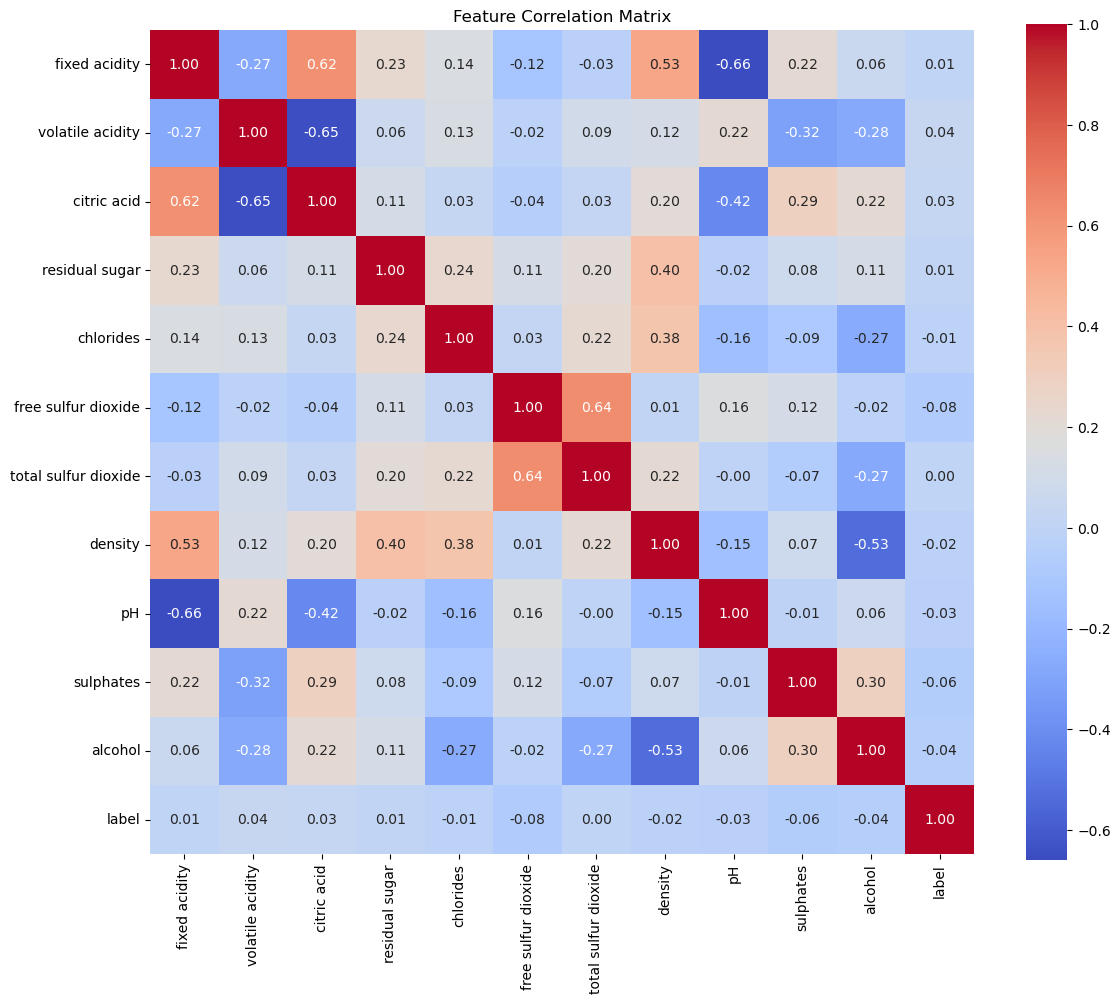

Correlation with label:
 free sulfur dioxide    -0.075606
sulphates              -0.057764
alcohol                -0.043470
volatile acidity        0.037546
citric acid             0.030885
pH                     -0.029011
density                -0.017507
chlorides              -0.014006
residual sugar          0.010442
fixed acidity           0.005717
total sulfur dioxide    0.004410
Name: label, dtype: float64

Confusion Matrix:
 [[134  14]
 [ 13  11]]

Accuracy: 84.3 %

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       148
           1       0.44      0.46      0.45        24

    accuracy                           0.84       172
   macro avg       0.68      0.68      0.68       172
weighted avg       0.85      0.84      0.84       172



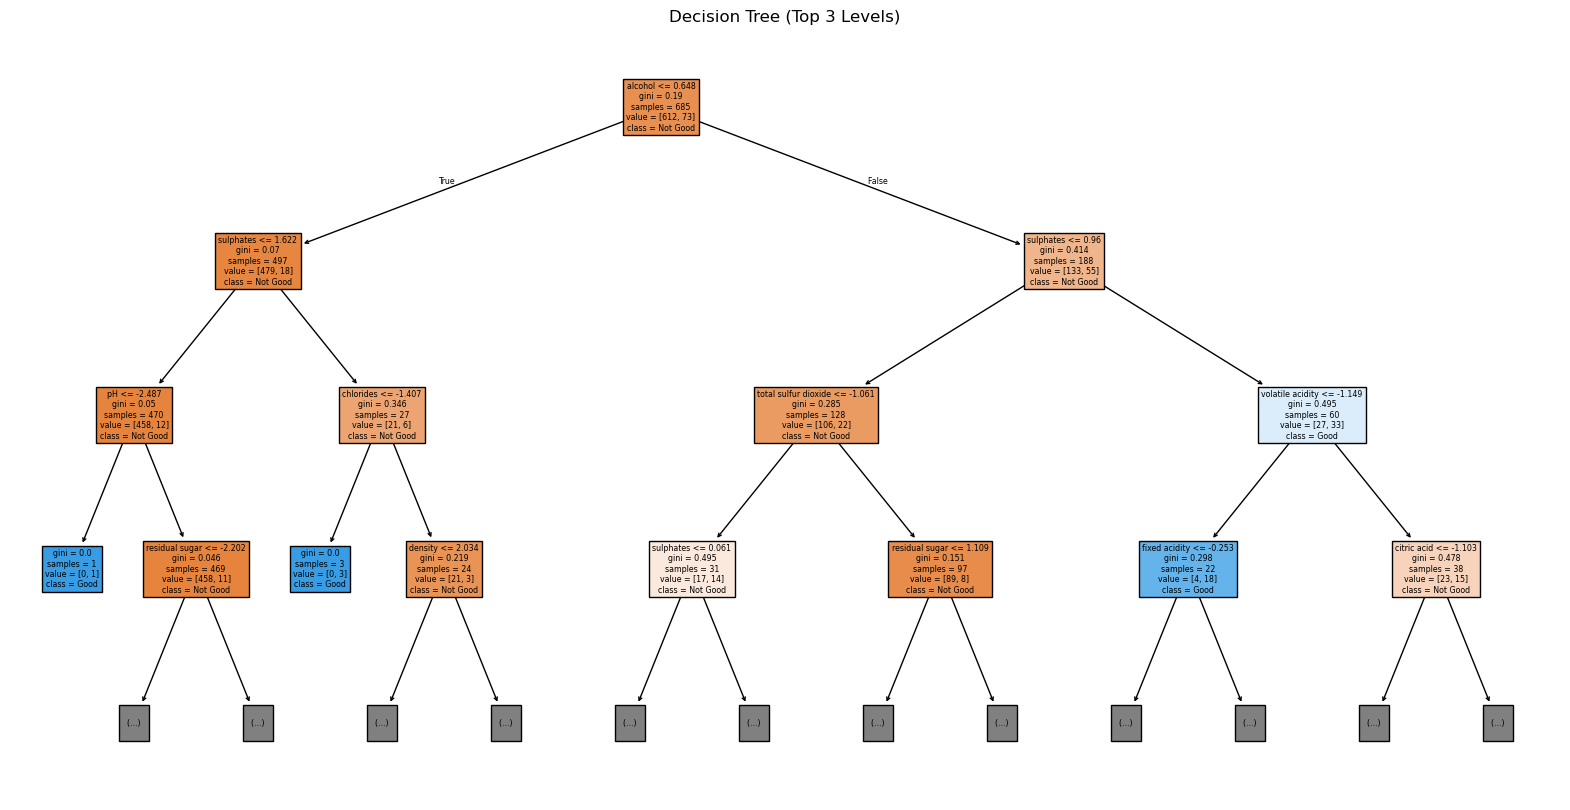

In [11]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load preprocessed data
X_train = joblib.load('X_train.pkl')
X_test = joblib.load('X_test.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

# Combine to form full dataframe for heatmap and correlation
feature_names = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
    'density', 'pH', 'sulphates', 'alcohol'
]

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

df_full = pd.concat([X_train_df, pd.Series(y_train, name='label')], axis=1)

# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_full.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# Sort correlations with label
label_corr = corr_matrix['label'].drop('label').sort_values(key=abs, ascending=False)
print("Correlation with label:\n", label_corr)

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_df, y_train)

# Predictions and Evaluation
y_pred = dt.predict(X_test_df)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", round(accuracy * 100, 2), "%")

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

# Plot Top 3 Levels of the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X_train_df.columns, class_names=["Not Good", "Good"], filled=True, max_depth=3)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()

# Save Model
import pickle
pickle.dump(dt, open('decision_tree_model.pkl', 'wb'))

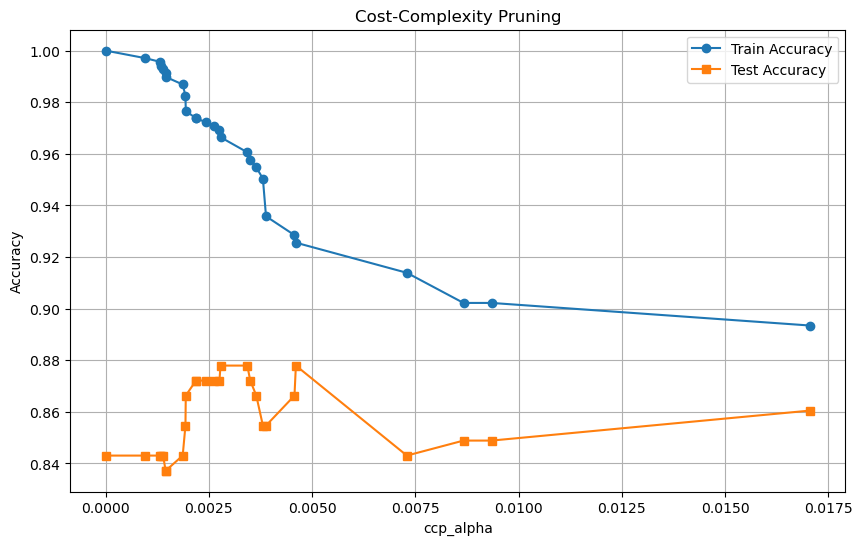

Best alpha: 0.002784368226207014


DecisionTreeClassifier(ccp_alpha=np.float64(0.002784368226207014),
                       random_state=42)

In [12]:
# Step 1: Train unpruned tree and get effective alphas
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_df, y_train)

ccp_alphas = path.ccp_alphas[:-1]  # Exclude the max alpha (which prunes everything)
clfs = []

# Step 2: Train multiple trees for each alpha
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    tree.fit(X_train_df, y_train)
    clfs.append(tree)

# Step 3: Evaluate and plot accuracy vs alpha
train_scores = [tree.score(X_train_df, y_train) for tree in clfs]
test_scores = [tree.score(X_test_df, y_test) for tree in clfs]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy")
plt.plot(ccp_alphas, test_scores, marker='s', label="Test Accuracy")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Cost-Complexity Pruning")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Pick best alpha (e.g., where test score peaks)
best_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[best_idx]
print("Best alpha:", best_alpha)

# Final model with pruning
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train_df, y_train)

Accuracy: 87.79 %

Confusion Matrix:
 [[142   6]
 [ 15   9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       148
           1       0.60      0.38      0.46        24

    accuracy                           0.88       172
   macro avg       0.75      0.67      0.70       172
weighted avg       0.86      0.88      0.87       172



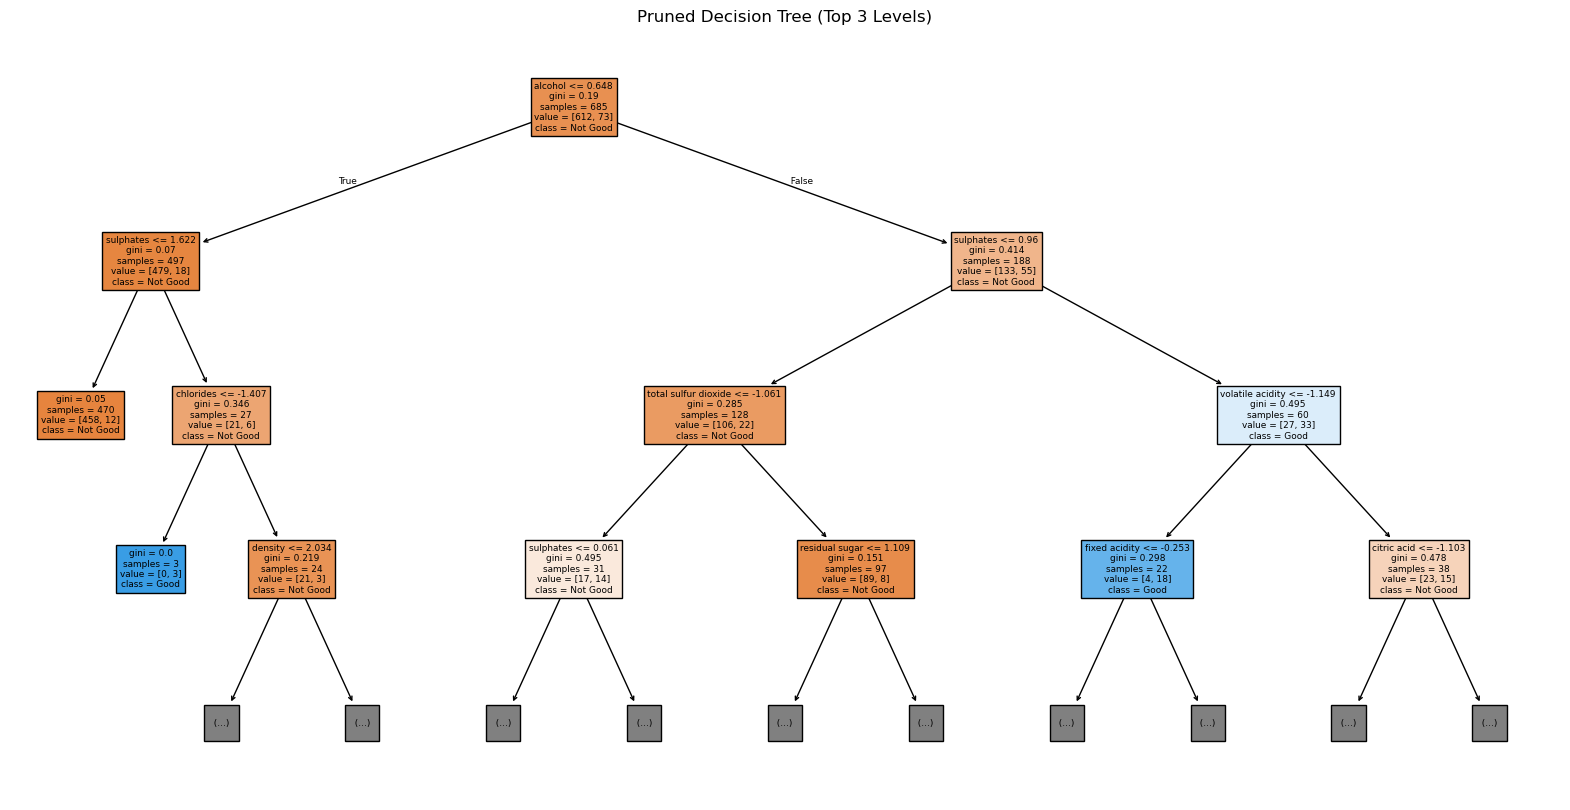

In [13]:
# Final model with pruning
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train_df, y_train)

# Evaluate
y_pred = pruned_tree.predict(X_test_df)
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize top of pruned tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X_train_df.columns, class_names=["Not Good", "Good"], filled=True, max_depth=3)
plt.title("Pruned Decision Tree (Top 3 Levels)")
plt.show()